In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load your dataset
df = pd.read_csv("D:\SLIIT\Y3-S1\FDM\Airline_preprocessed.csv")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (103904, 23)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,0,13,1,2,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,0,26,0,0,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,0,25,0,0,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,0,61,0,0,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


Check for Missing Values

In [4]:
# Check missing values before feature selection
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])

Missing values per column:
Series([], dtype: int64)


Encode Categorical Variables for Analysis

In [5]:
# Create a copy for encoding
df_encoded = df.copy()

# Encode target variable
le_target = LabelEncoder()
df_encoded['satisfaction'] = le_target.fit_transform(df['satisfaction'])

# Encode categorical features
cat_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
for col in cat_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])

print("Encoding completed")
df_encoded.head()

Encoding completed


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,0,13,1,2,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,0,26,0,0,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,0,25,0,0,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,0,61,0,0,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


Feature Correlation Analysis

Feature Correlation with Satisfaction:
satisfaction                         1.000000
Online boarding                      0.503557
Class                                0.449321
Type of Travel                       0.449000
Inflight entertainment               0.398059
Seat comfort                         0.349459
On-board service                     0.322383
Leg room service                     0.313131
Cleanliness                          0.305198
Flight Distance                      0.298780
Inflight wifi service                0.284245
Baggage handling                     0.247749
Inflight service                     0.244741
Checkin service                      0.236174
Food and drink                       0.209936
Customer Type                        0.187638
Ease of Online booking               0.171705
Age                                  0.137167
Arrival Delay in Minutes             0.057497
Departure/Arrival time convenient    0.051601
Departure Delay in Minutes           0.05

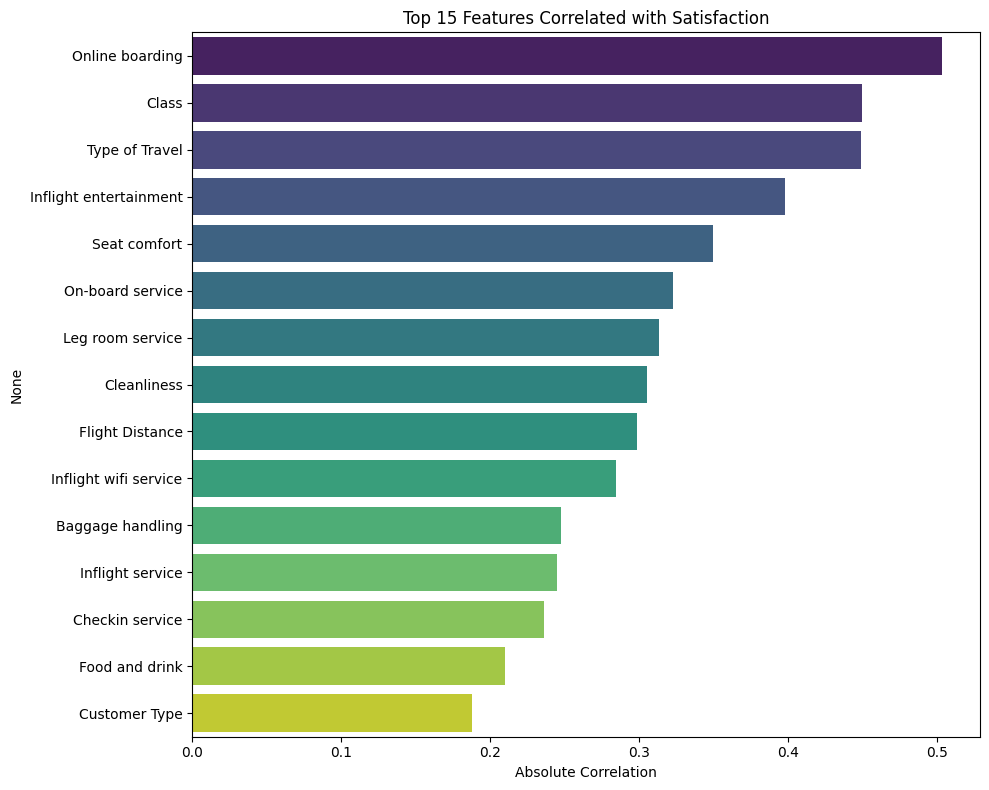

In [6]:
# Calculate correlation with target variable
correlation = df_encoded.corr()['satisfaction'].abs().sort_values(ascending=False)
print("Feature Correlation with Satisfaction:")
print(correlation)

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_corr = correlation[1:16]  # Exclude satisfaction itself
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top 15 Features Correlated with Satisfaction')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

 Identify Multicollinearity (Redundant Features)

In [7]:
# Check correlation between features to identify redundancy
corr_matrix = df_encoded.corr().abs()

# Find highly correlated feature pairs (threshold: 0.8)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_features = [
    column for column in upper_triangle.columns 
    if any(upper_triangle[column] > 0.8)
]

print("Highly correlated (redundant) features:")
print(high_corr_features)

Highly correlated (redundant) features:
['Arrival Delay in Minutes']


Feature Engineering - Create New Features

In [8]:
# Based on member 1's work, create aggregate features
service_cols = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 
    'Ease of Online booking', 'Gate location', 'Food and drink',
    'Online boarding', 'Seat comfort', 'Inflight entertainment',
    'On-board service', 'Leg room service', 'Baggage handling',
    'Checkin service', 'Inflight service', 'Cleanliness'
]

# Create aggregated service scores
df_encoded['TotalServiceScore'] = df_encoded[service_cols].sum(axis=1)
df_encoded['AvgServiceScore'] = df_encoded[service_cols].mean(axis=1)

# Create delay indicator
df_encoded['HasDelay'] = ((df_encoded['Departure Delay in Minutes'] > 0) | 
                          (df_encoded['Arrival Delay in Minutes'] > 0)).astype(int)

# Create age groups
df_encoded['AgeGroup'] = pd.cut(df_encoded['Age'], 
                                 bins=[0, 25, 40, 60, 100], 
                                 labels=[0, 1, 2, 3])

# Create distance categories
df_encoded['DistanceCategory'] = pd.cut(df_encoded['Flight Distance'], 
                                         bins=[0, 500, 1500, 5000], 
                                         labels=[0, 1, 2])

print("New features created successfully")
print(f"New dataset shape: {df_encoded.shape}")
df_encoded.head()

New features created successfully
New dataset shape: (103904, 28)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,TotalServiceScore,AvgServiceScore,HasDelay,AgeGroup,DistanceCategory
0,1,0,13,1,2,460,3,4,3,1,...,5,5,25,18.0,0,54,3.857143,1,0,0
1,1,1,25,0,0,235,3,2,3,3,...,4,1,1,6.0,0,32,2.285714,1,0,0
2,0,0,26,0,0,1142,2,2,2,2,...,4,5,0,0.0,1,52,3.714286,0,1,1
3,0,0,25,0,0,562,2,5,5,5,...,4,2,11,9.0,0,42,3.000000,1,0,1
4,1,0,61,0,0,214,3,3,3,3,...,3,3,0,0.0,1,49,3.500000,0,3,0


Feature Importance using Random Forest

Top 20 Important Features:
                              Feature  Importance
11                    Online boarding    0.166316
6               Inflight wifi service    0.130859
3                      Type of Travel    0.092315
4                               Class    0.092074
23                    AvgServiceScore    0.063892
22                  TotalServiceScore    0.047545
13             Inflight entertainment    0.037016
8              Ease of Online booking    0.035579
5                     Flight Distance    0.031194
12                       Seat comfort    0.031192
1                       Customer Type    0.029915
15                   Leg room service    0.027115
2                                 Age    0.026395
14                   On-board service    0.023614
17                    Checkin service    0.019880
18                   Inflight service    0.018525
19                        Cleanliness    0.018484
16                   Baggage handling    0.018473
7   Departure/Arrival t

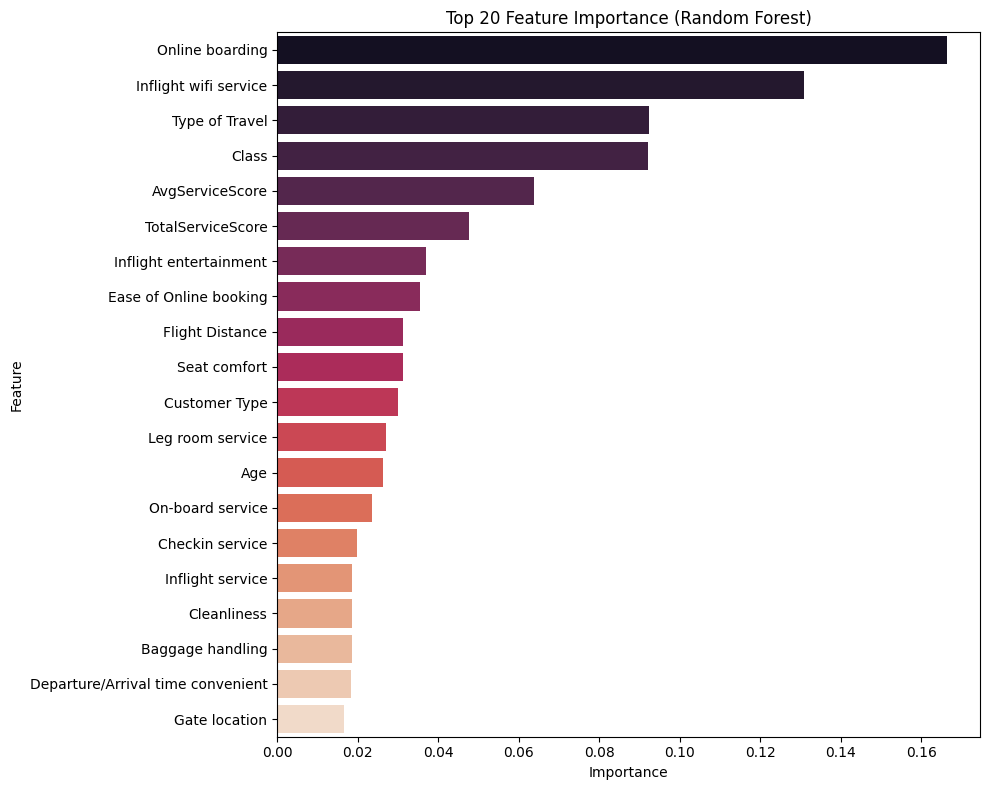

In [9]:
# Prepare features and target
X = df_encoded.drop(['satisfaction'], axis=1)
y = df_encoded['satisfaction']

# Train Random Forest to get feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Important Features:")
print(feature_importance.head(20))

# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature', palette='rocket')
plt.title('Top 20 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

Select Top K Features (Chi-Square Test)


Top 20 Selected Features (Chi-Square):
['Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'TotalServiceScore', 'AvgServiceScore', 'DistanceCategory']

Chi-Square Scores:
                       Feature    Chi2_Score
5              Flight Distance  7.954222e+06
22           TotalServiceScore  6.999438e+04
21    Arrival Delay in Minutes  3.170059e+04
20  Departure Delay in Minutes  2.448241e+04
2                          Age  1.338015e+04
11             Online boarding  1.128886e+04
13      Inflight entertainment  6.712360e+03
4                        Class  5.071290e+03
12                Seat comfort  4.973284e+03
14            On-board service  4.090095e+03
15            Leg room service  4.052620e+03
6        I

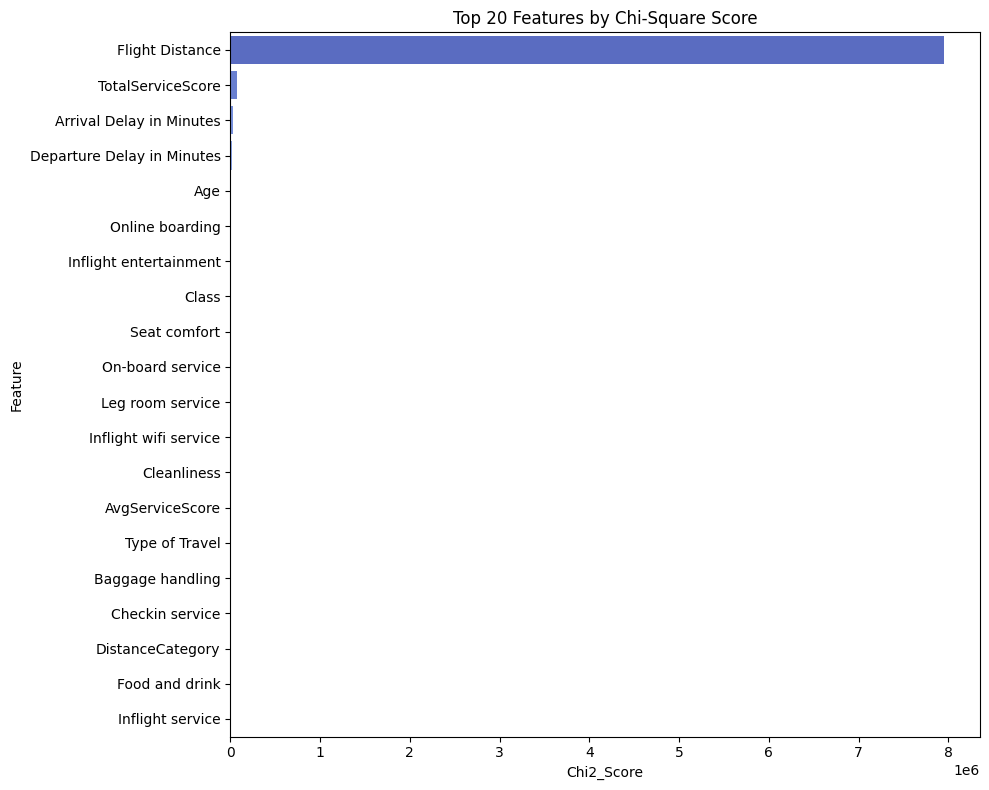

In [10]:
# Select top features using Chi-Square test
k_best = 20  # Select top 20 features

# Convert all categorical columns to numeric
X_numeric = X.copy()
for col in X_numeric.columns:
    if X_numeric[col].dtype.name == 'category':
        X_numeric[col] = X_numeric[col].astype(int)

# Ensure all values are non-negative for chi2
X_positive = X_numeric - X_numeric.min() + 1

# Apply Chi-Square feature selection
selector = SelectKBest(score_func=chi2, k=k_best)
X_selected = selector.fit_transform(X_positive, y)

# Get selected feature names
selected_features = X_numeric.columns[selector.get_support()].tolist()
print(f"\nTop {k_best} Selected Features (Chi-Square):")
print(selected_features)

# Get chi-square scores
chi2_scores = pd.DataFrame({
    'Feature': X_numeric.columns,
    'Chi2_Score': selector.scores_
}).sort_values('Chi2_Score', ascending=False)

print("\nChi-Square Scores:")
print(chi2_scores.head(20))

# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(data=chi2_scores.head(20), x='Chi2_Score', y='Feature', palette='coolwarm')
plt.title('Top 20 Features by Chi-Square Score')
plt.tight_layout()
plt.show()

Mutual Information Feature Selection

Top 20 Features by Mutual Information:
                   Feature  MI_Score
11         Online boarding  0.213936
6    Inflight wifi service  0.165189
22       TotalServiceScore  0.149263
23         AvgServiceScore  0.146869
4                    Class  0.140894
3           Type of Travel  0.117228
13  Inflight entertainment  0.094737
12            Seat comfort  0.082827
15        Leg room service  0.065393
5          Flight Distance  0.063348
14        On-board service  0.058495
19             Cleanliness  0.054085
8   Ease of Online booking  0.053774
26        DistanceCategory  0.050069
2                      Age  0.047910
16        Baggage handling  0.046656
18        Inflight service  0.044412
25                AgeGroup  0.042621
17         Checkin service  0.035857
10          Food and drink  0.028586


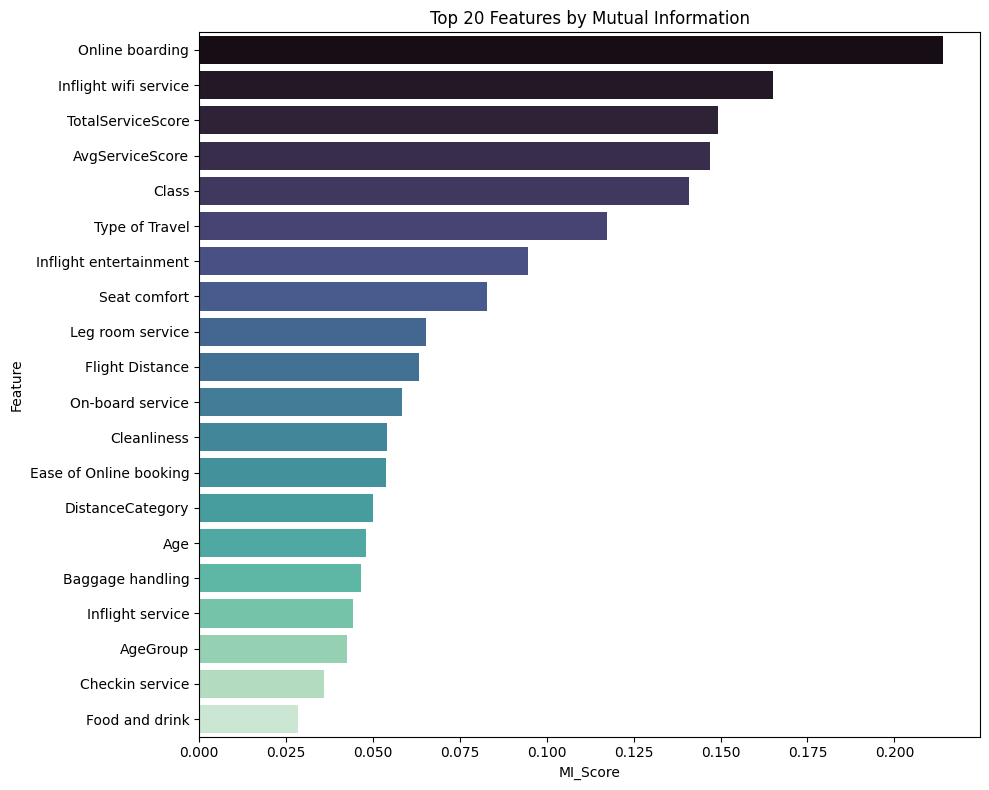

In [11]:
# Calculate mutual information scores
X_numeric = X.copy()
for col in X_numeric.columns:
    if X_numeric[col].dtype.name == 'category':
        X_numeric[col] = X_numeric[col].astype(int)

mi_scores = mutual_info_classif(X_numeric, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_numeric.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Top 20 Features by Mutual Information:")
print(mi_df.head(20))

# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(data=mi_df.head(20), x='MI_Score', y='Feature', palette='mako')
plt.title('Top 20 Features by Mutual Information')
plt.tight_layout()
plt.show()

Remove Low Importance Features

In [12]:
# Define threshold for feature importance
importance_threshold = 0.01

# Select features above threshold
important_features = feature_importance[
    feature_importance['Importance'] > importance_threshold
]['Feature'].tolist()

print(f"Features selected (importance > {importance_threshold}): {len(important_features)}")
print(f"Features removed: {len(X.columns) - len(important_features)}")

# Create final feature set
X_final = df_encoded[important_features]
print(f"\nFinal feature set shape: {X_final.shape}")

# Features dropped (importance <= threshold)
dropped_features = feature_importance[
    feature_importance['Importance'] <= importance_threshold
]['Feature'].tolist()

print("\nDropped Features:")
print(dropped_features)

Features selected (importance > 0.01): 22
Features removed: 5

Final feature set shape: (103904, 22)

Dropped Features:
['Departure Delay in Minutes', 'Food and drink', 'AgeGroup', 'Gender', 'HasDelay']


Save the dataset after processing with selection features

In [13]:
# Save the final processed dataset for the next member
df_final = df_encoded[important_features + ['satisfaction']]
df_final.to_csv('airline_processed_data.csv', index=False)

print("✓ Processed dataset saved successfully!")
print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Features saved: {len(important_features)}")
print(f"File created: processed_data.csv")
print("\nThis file is ready for Member 3 (Data Preprocessing) and Member 4 (Model Development)")

✓ Processed dataset saved successfully!

Final dataset shape: (103904, 23)
Features saved: 22
File created: processed_data.csv

This file is ready for Member 3 (Data Preprocessing) and Member 4 (Model Development)


Feature Selection Summary Report


=== FEATURE SELECTION SUMMARY ===
                    Metric  Value
 Total Features (Original)     22
Features After Engineering     27
 Features Selected (Final)     22
          Features Removed      5
             Total Samples 103904


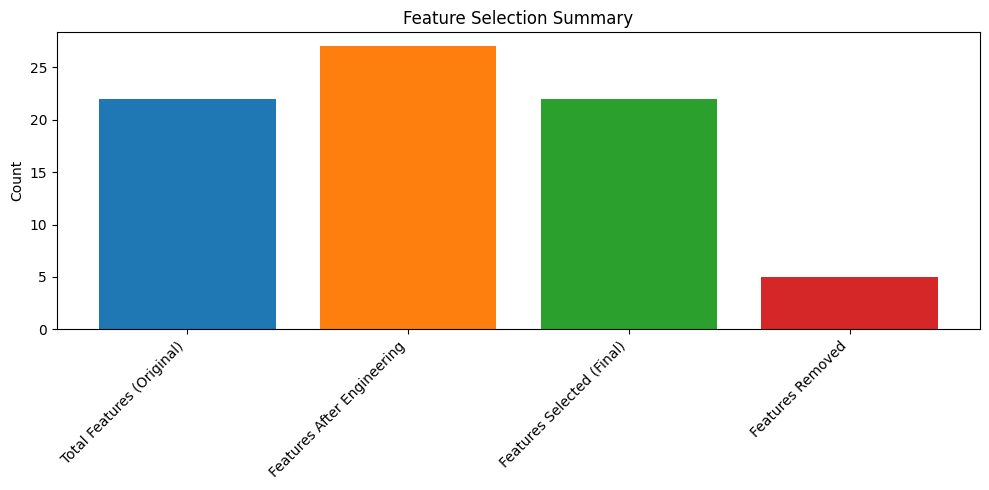

In [14]:
# Create summary report
summary = {
    'Total Features (Original)': len(df.columns) - 1,  # Exclude target
    'Features After Engineering': len(X.columns),
    'Features Selected (Final)': len(important_features),
    'Features Removed': len(X.columns) - len(important_features),
    'Total Samples': len(df_final)
}

summary_df = pd.DataFrame(summary.items(), columns=['Metric', 'Value'])
print("\n=== FEATURE SELECTION SUMMARY ===")
print(summary_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(summary_df['Metric'][:4], summary_df['Value'][:4], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Feature Selection Summary')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.show()